In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [193]:
%load_ext rpy2.ipython
%R library(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [194]:
ab = pd.read_csv('data/pitch/atbats.csv')

In [195]:
ab.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [196]:
ab2018 = ab.loc[ab.ab_id.astype(str).str.startswith('2018')]
ab2018.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
554815,2018000001,446359,Strikeout,201800001,1,1,0,R,608665,R,True
554816,2018000002,545361,Groundout,201800001,1,2,0,R,608665,R,True
554817,2018000003,457708,Pop Out,201800001,1,3,0,R,608665,R,True
554818,2018000004,459964,Single,201800001,1,0,0,R,572070,L,False
554819,2018000005,543760,Single,201800001,1,0,0,R,572070,R,False


In [197]:
names = pd.read_csv('data/pitch/player_names.csv')

In [198]:
named_ab = pd.merge(ab2018, names, left_on = 'batter_id', right_on = 'id', how = 'left')
first, last = ['Mookie', 'Mike', 'Jose', 'J.D.', 'Alex'], ['Betts', 'Trout', 'Ramirez', 'Martinez', 'Bregman']
mvps = named_ab.loc[(named_ab.first_name.isin(first)) & (named_ab.last_name.isin(last))]

In [199]:
trout = mvps.loc[mvps.last_name == 'Trout']
betts = mvps.loc[mvps.last_name == 'Betts']
martinez = mvps.loc[(mvps.last_name == 'Martinez') & (mvps.first_name == 'J.D.')]
ramirez = mvps.loc[mvps.last_name == 'Ramirez']
bregman = mvps.loc[mvps.last_name == 'Bregman']

In [200]:
bregman['HR'] = np.where(bregman.event == 'Home Run', 1, 0)
bregman['HR'].sum()

31

In [201]:
mvps.event.unique()

array(['Groundout', 'Flyout', 'Pop Out', 'Strikeout', 'Walk', 'Single',
       'Forceout', 'Grounded Into DP', 'Double', 'Home Run', 'Lineout',
       'Runner Out', 'Fielders Choice', 'Hit By Pitch', 'Sac Fly',
       'Triple', 'Intent Walk', 'Field Error', 'Batter Interference',
       'Fielders Choice Out', 'Double Play', 'Strikeout - DP',
       'Catcher Interference', 'Sac Bunt'], dtype=object)

In [202]:
on_base = ['Walk', 'Single', 'Double', 'Home Run', 'Hit By Pitch', 'Triple', 'Intent Walk']

In [203]:
def create_cols(df):
    # create ab bat index
    df['ab_num'] = df.reset_index().index + 1 - 50
    # create on base percentage over rolling 50 at bats
    df['on_base_flag'] = np.where(df.event.isin(on_base), 1, 0)
    df['ob_pct'] = df.on_base_flag.rolling(50).sum() / 50
    # create sum of HR's over rolling 50 at bats
    df['HR'] = np.where(df.event == 'Home Run', 1, 0)
    df['HR_rolling'] = df.HR.rolling(50).sum()
    # create slugging percentage, ie total bases / at bats
    df['total_bases'] = 0
    df.loc[(df.event.isin(['Walk', 'Single', 'Hit By Pitch', 'Intent Walk'])), 'total_bases'] = 1
    df.loc[df.event == 'Double', 'total_bases'] = 2
    df.loc[df.event == 'Triple', 'total_bases'] = 3
    df.loc[df.event == 'Home Run', 'total_bases'] = 4
    df['Slugging'] = df.total_bases.rolling(50).mean()
    df = df[['first_name', 'last_name', 'ab_num', 'event','on_base_flag', 'ob_pct', 'Slugging', 'HR_rolling']]
    return df.iloc[49:]

In [204]:
trout = create_cols(trout)
betts = create_cols(betts)
martinez = create_cols(martinez)
ramirez = create_cols(ramirez)
bregman = create_cols(bregman)

In [205]:
combined = pd.concat([trout, betts, martinez, ramirez, bregman])

In [206]:
%R -i combined

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



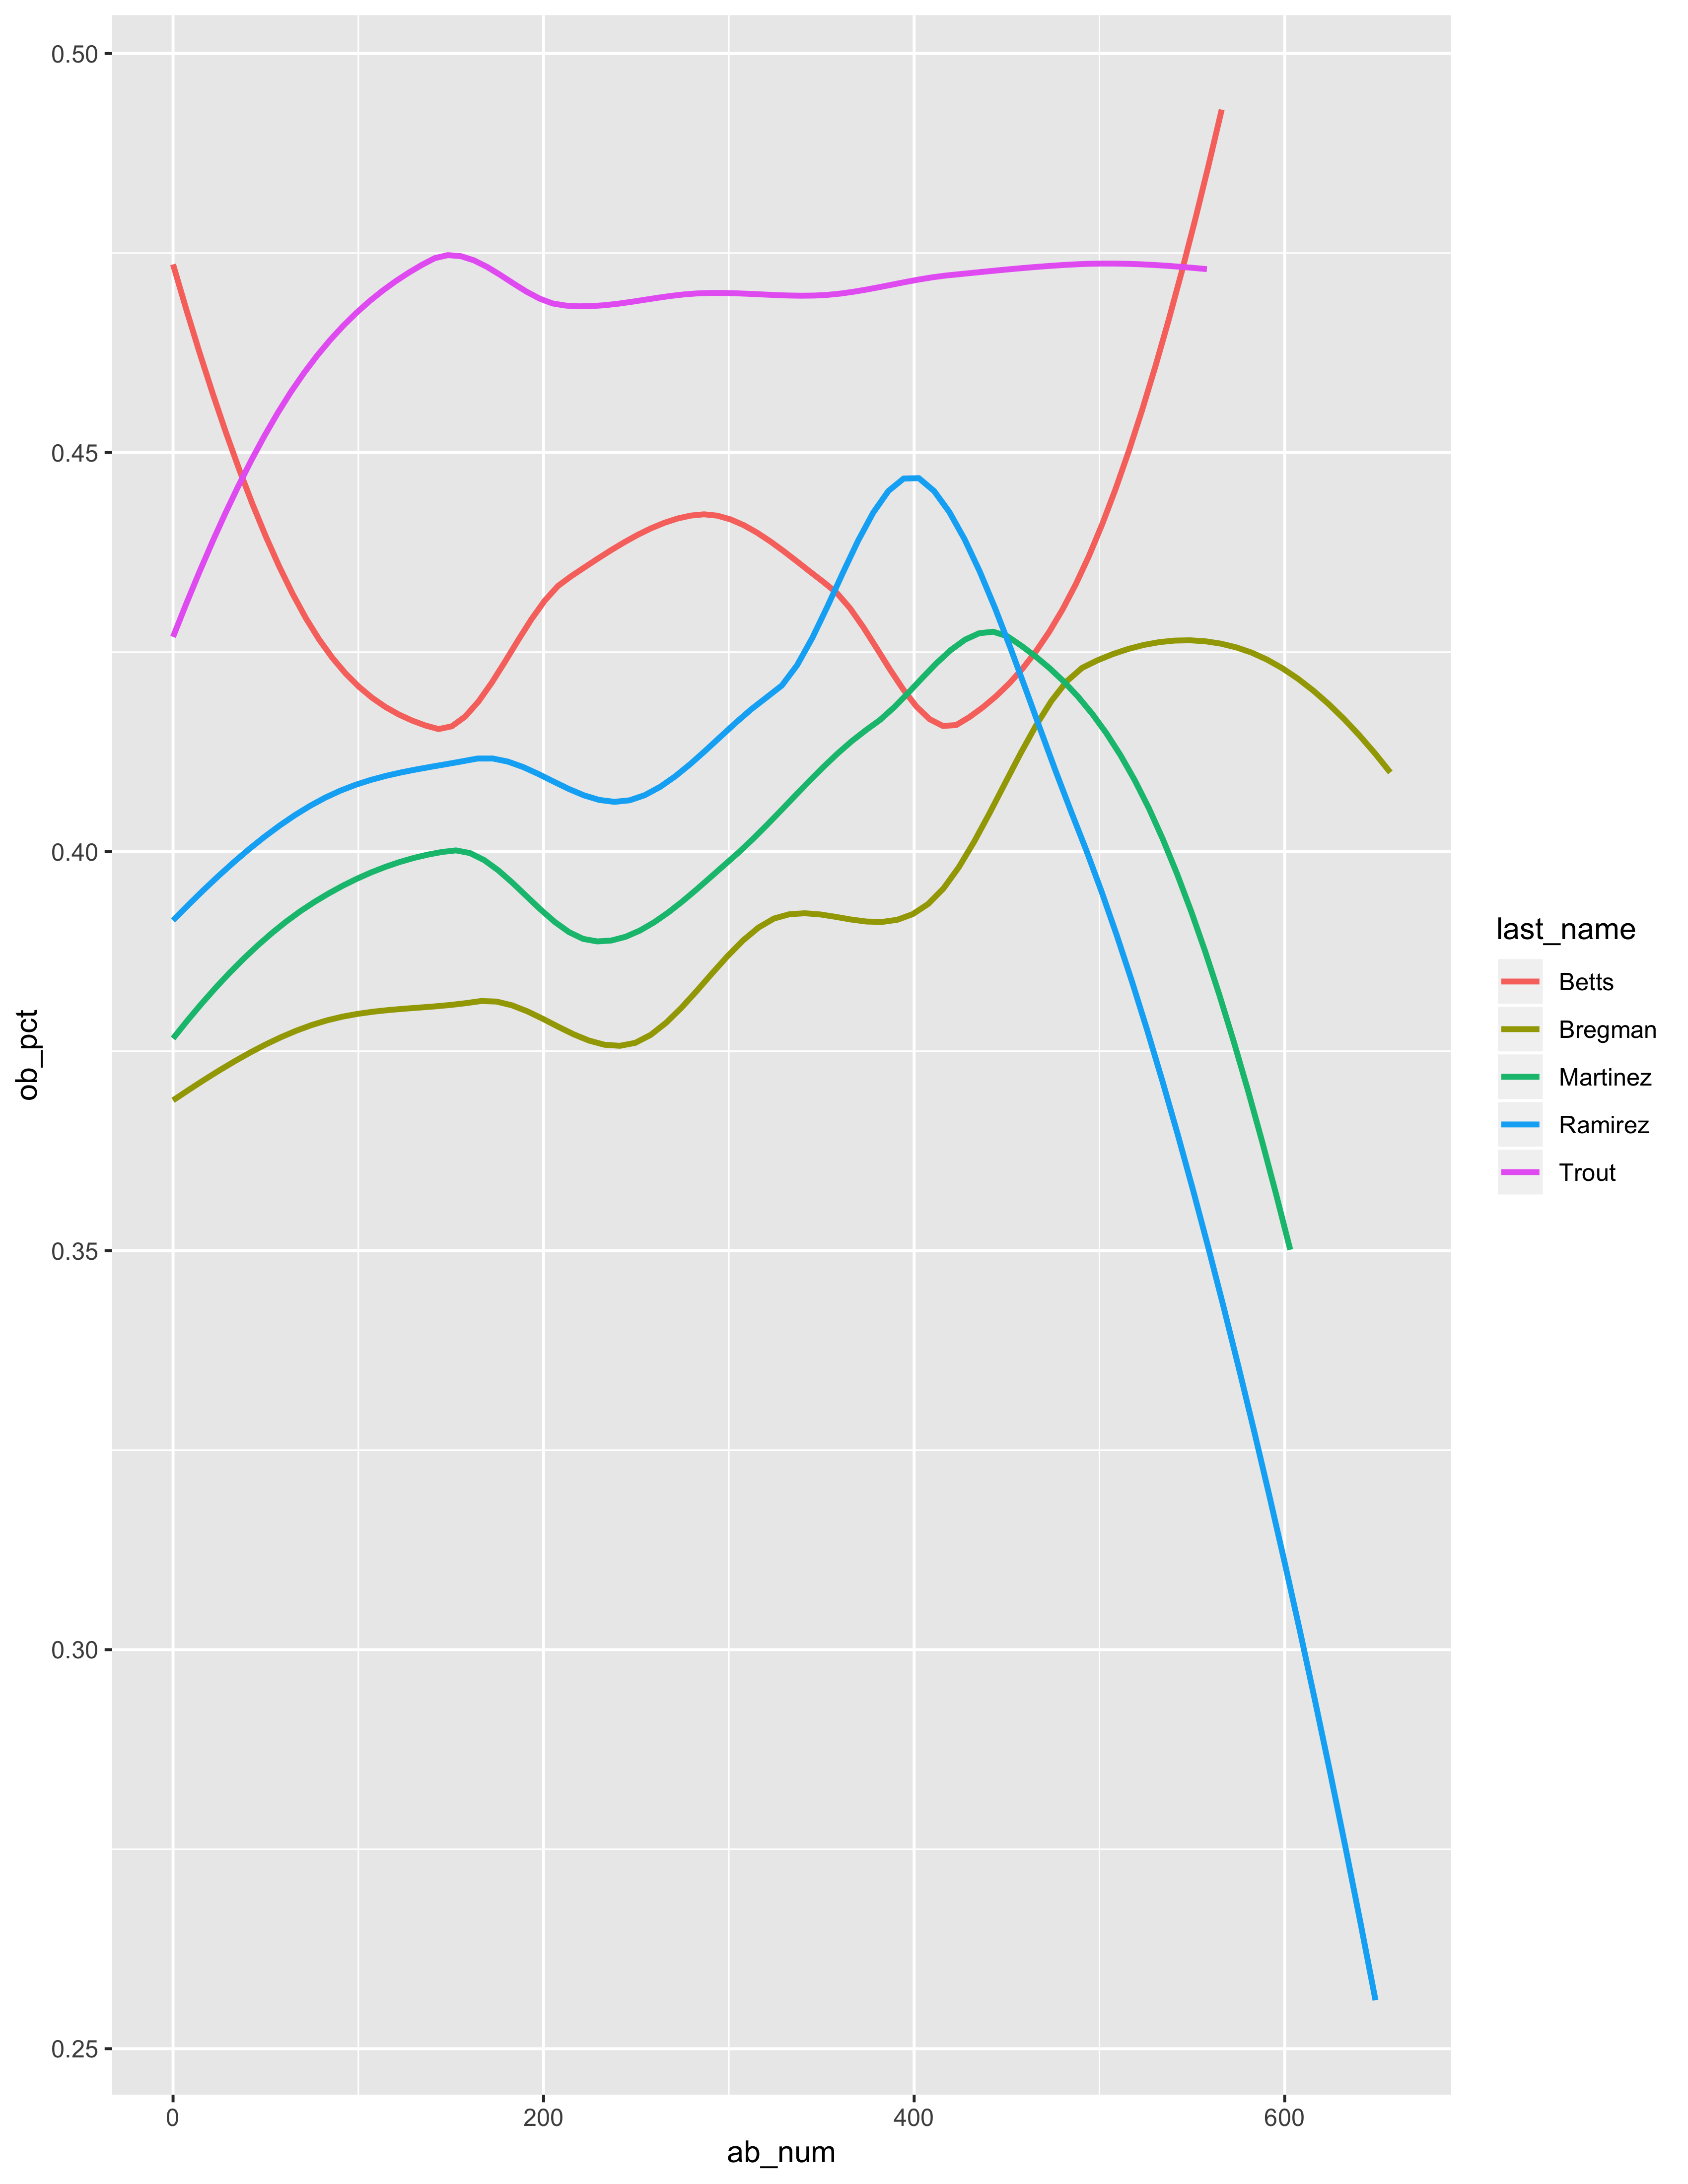

In [212]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + geom_smooth(aes(x=ab_num, y = ob_pct, group = last_name, color = last_name), 
                       data = combined, se = F)